In [ ]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np


In [ ]:
import pandas as pd

pd.set_option("display.precision", 8)

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.12.0
Hub version:  0.13.0
Eager mode:  True
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root='/content/drive/My Drive/DatasetImageClassification';


In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE)

/content/drive/My Drive/DatasetImageClassification
Found 600 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 10)
['Aile' 'Baba' 'Bilgisayar' 'Bunaldım' 'Ev' 'GüLe GüLe' 'Kız' 'Merhaba'
 'ÖZüR Dilerim' 'Saat']


In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/10
75/75 [==============================] - 876s 12s/step - loss: 1.1477 - acc: 0.6704 - val_loss: 0.3511 - val_acc: 0.9833
Epoch 2/10
75/75 [==============================] - 24s 313ms/step - loss: 0.2704 - acc: 0.9746 - val_loss: 0.1323 - val_acc: 0.9967
Epoch 3/10
75/75 [==============================] - 23s 307ms/step - loss: 0.1302 - acc: 0.9929 - val_loss: 0.0744 - val_acc: 0.9950
Epoch 4/10
75/75 [==============================] - 25s 328ms/step - loss: 0.0819 - acc: 0.9962 - val_loss: 0.0499 - val_acc: 0.9983
Epoch 5/10
75/75 [==============================] - 29s 384ms/step - loss: 0.0594 - acc: 0.9971 - val_loss: 0.0365 - val_acc: 1.0000
Epoch 6/10
75/75 [==============================] - 24s 317ms/step - loss: 0.0415 - acc: 0.9987 - val_loss: 0.0277 - val_acc: 1.0000
Epoch 7/10
75/75 [==============================] - 24s 316ms/step - loss: 0.0347 - acc: 0.9992 - val_loss: 0.0233 - val_acc: 0.9983
Epoch 8/10
75/75 [==============================] - 23s 311ms/step - l

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

19/19 [==============================] - 8s 407ms/step - loss: 0.0136 - acc: 1.0000
Final loss: 0.01
Final accuracy: 100.00%


In [ ]:
pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
SIGN_SAVED_MODEL = "saved_models/image_model"
model.save(SIGN_SAVED_MODEL)
sign_model = tf.keras.models.load_model(SIGN_SAVED_MODEL,
                                        custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
tf_model_predictions = sign_model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 1s 841ms/step
Prediction results shape: (32, 10)


In [ ]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Aile,Baba,Bilgisayar,Bunaldım,Ev,GüLe GüLe,Kız,Merhaba,ÖZüR Dilerim,Saat
0,0.00012358,0.00015969,0.00009718,0.00007776,0.00014042,0.00001229,0.00000897,0.00000193,0.99937052,0.00000759
1,0.00017504,0.00024562,0.00053639,0.00025079,0.00000479,0.00423758,0.00043528,0.99405366,0.00003905,0.00002172
2,0.00013560,0.00015267,0.00027443,0.00016653,0.00000201,0.00159564,0.00026893,0.99737346,0.00002303,0.00000771
3,0.00110367,0.00001770,0.00118264,0.00018189,0.00001526,0.00002454,0.00005371,0.00000271,0.00013283,0.99728513
4,0.00067326,0.00044760,0.00007228,0.99394411,0.00004352,0.00025407,0.00350037,0.00008968,0.00045093,0.00052411


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

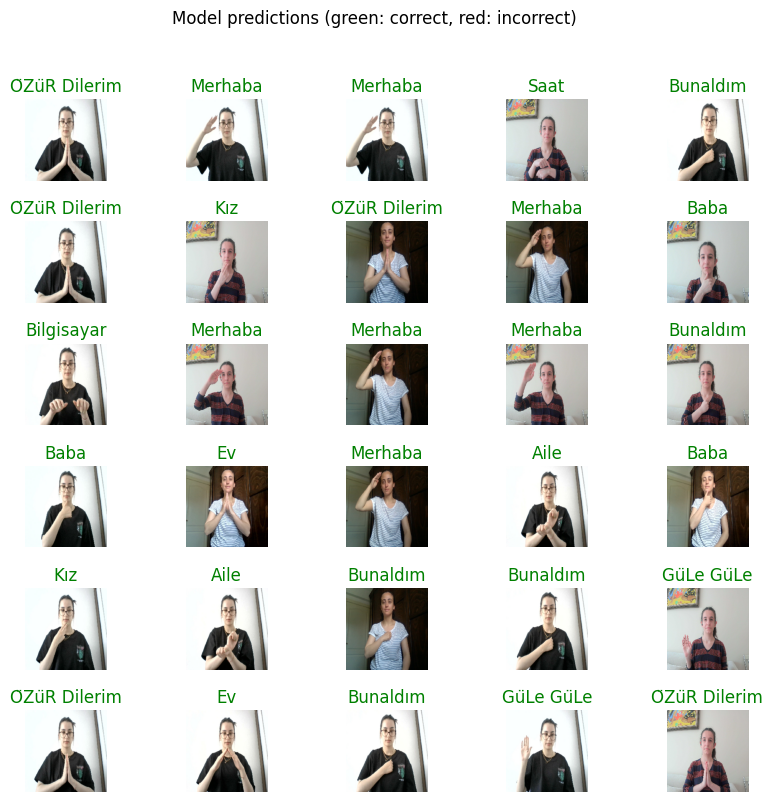

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
!mkdir "tflite_models"

In [ ]:
TFLITE_MODEL = "tflite_models/sign.tflite"

In [ ]:
run_model = tf.function(lambda x : sign_model(x))
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SIGN_SAVED_MODEL)
tflite_model = converter.convert()

In [ ]:
open(TFLITE_MODEL, "wb").write(tflite_model)

8916272